In [1]:
import numpy as np                               # 向量和矩阵
import pandas as pd                              # 表格和数据处理
import matplotlib.pyplot as plt                  # 绘图
import seaborn as sns                            # 更多绘图功能

from dateutil.relativedelta import relativedelta # 处理不同格式的时间日期
from scipy.optimize import minimize              # 最小化函数

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # 一些有用的函数
from tqdm import tqdm_notebook

import warnings                                  # 勿扰模式
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:

# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

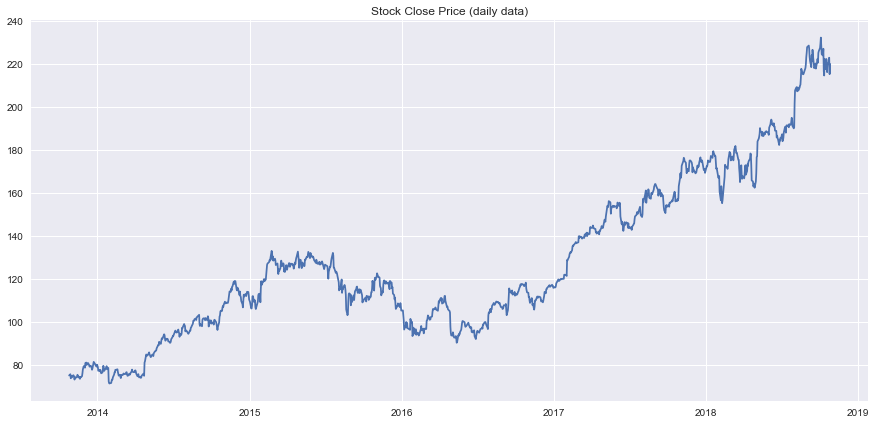

In [3]:
stock = pd.read_csv('/Users/BartSu/Desktop/AAPL.csv', index_col=['Date'], parse_dates=['Date'])
plt.figure(figsize=(15,7))
plt.plot(stock.Close)
plt.title('Stock Close Price (daily data)')
plt.grid(True)
plt.show()

In [4]:
# 引入上面提到的所有测度
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error # 没有mean_squared_log_error

# 自行实现sklearn没有提供的平均绝对百分误差很容易
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def moving_average(series, n):
    """
        计算前n项观测的平均数
    """
    return np.average(series[-n:])

# 根据前24小时的数据预测
moving_average(stock['Close'], 30)

221.62866613333333

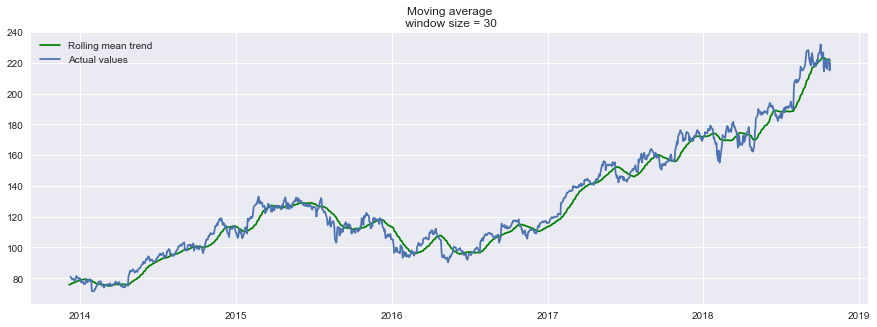

In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - 时序dateframe
        window - 滑窗大小 
        plot_intervals - 显示置信区间
        plot_anomalies - 显示异常值 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # 绘制平滑后的数据的置信区间
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # 得到区间后，找出异常值
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
# plt.grid(True)

plotMovingAverage(stock['Close'], 30)

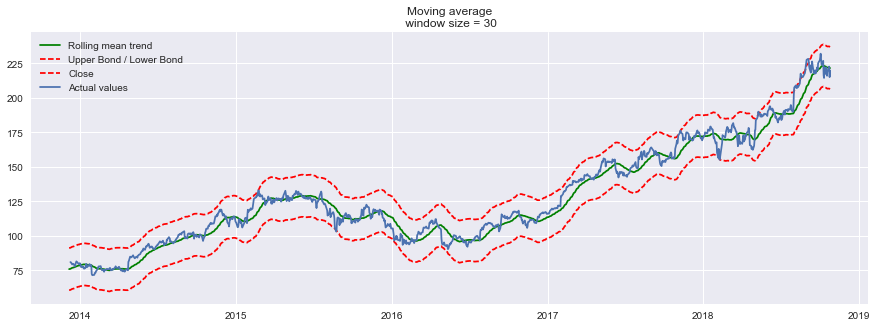

In [7]:
#平滑值的置信区间
plotMovingAverage(stock['Close'], 30, plot_intervals=True)

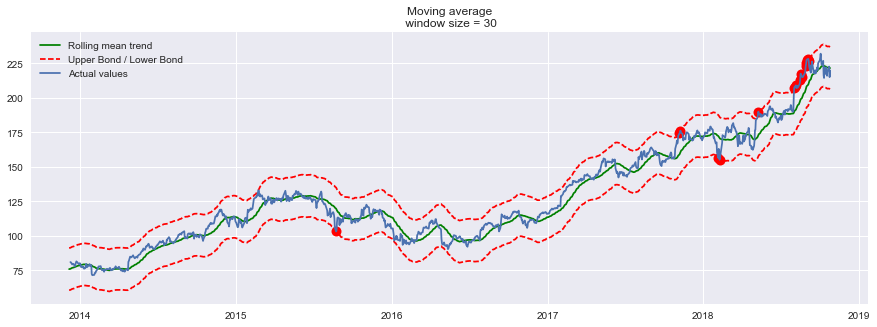

In [8]:
#异常检测系统
stock_anomaly = pd.read_csv('/Users/BartSu/Desktop/AAPL-Close.csv', index_col=['Date'], parse_dates=['Date'])
# 例如股价突然下降5%
# stock_anomaly.iloc[-5] = stock_anomaly.iloc[-5] * 0.2
plotMovingAverage(stock_anomaly, 30, plot_intervals=True, plot_anomalies=True)

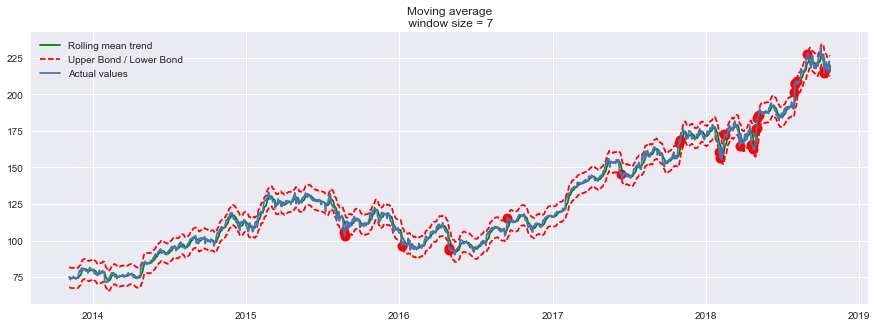

In [9]:
# 按周平滑
plotMovingAverage(stock_anomaly, 7, plot_intervals=True, plot_anomalies=True)

In [10]:
# 加权平均，不同的观测具有不同的权重，所有权重和为一。通常最近观测的数据有较高权重。
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

weighted_average(stock_anomaly, [0.6, 0.3, 0.1])

220.14499669999998

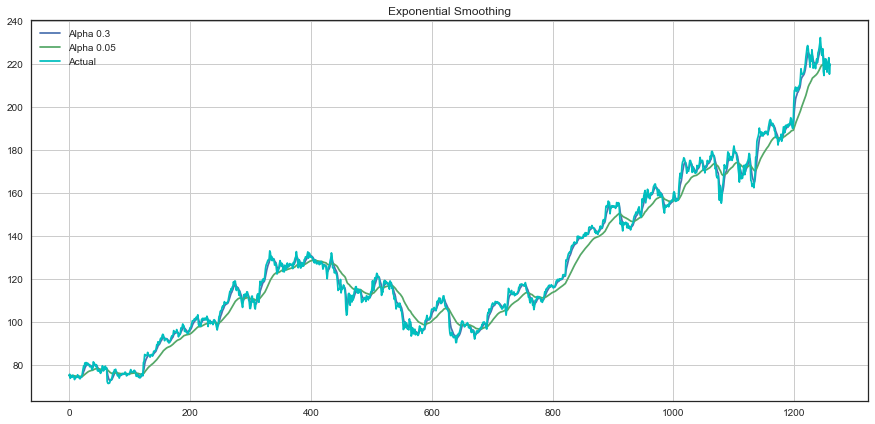

In [11]:
#指数平滑
def exponential_smoothing(series, alpha):
    """
        series - 时序数据集
        alpha - 浮点数，范围[0.0, 1.0]，平滑参数
    """
    result = [series[0]] # 第一项和序列第一项相同 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

plotExponentialSmoothing(stock['Close'], [0.3, 0.05])


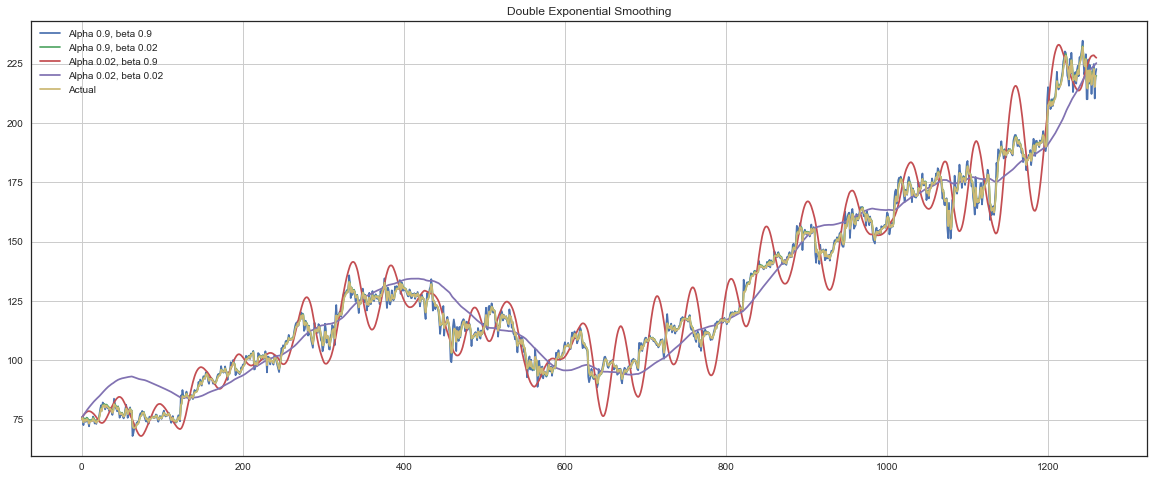

In [12]:
# 双指数平滑
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

plotDoubleExponentialSmoothing(stock['Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])
# α和β。前者根据趋势平滑序列，后者平滑趋势本身。这两个参数越大，最新的观测的权重就越高，建模的序列就越不平滑

In [13]:
# Holt-Winters模型, 三次指数平滑， 加入季节性
class HoltWinters:

    """
    Holt-Winters模型，使用Brutlag方法检测异常

    # series - 初始时序
    # slen - 季节长度
    # alpha, beta, gamma - Holt-Winters模型参数
    # n_preds - 预测视野
    # scaling_factor - 设置Brutlag方法的置信区间（通常位于2到3之间） 

    """


    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor


    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # 计算季节平均
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # 计算初始值
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   


    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # 成分初始化
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series): # 预测
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # 预测时在每一步增加不确定性
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # 据Brutlag算法计算偏差
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [14]:
# 时序交叉验证
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # 设定交叉验证折数
    tscv = TimeSeriesSplit(n_splits=3) 

    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [15]:
stock_close = pd.read_excel('/Users/BartSu/Desktop/AAPL-Close.xlsx')

# 牛顿共轭梯度（Truncated Newton conjugate gradient）
data = stock_close['Close'][:-100] # 留置一些数据用于测试

# 初始化模型参数alpha、beta、gamma
x = [0, 0, 0]

# 最小化损失函数
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error),  # mean_squared_log_error : Mean Squared Logarithmic Error cannot be used when targets contain negative values
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
)

# 取最优值……
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ……并据此训练模型，预测接下来50天的数据
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.4087481184435463 0.001537743265279945 0.26427294412065927


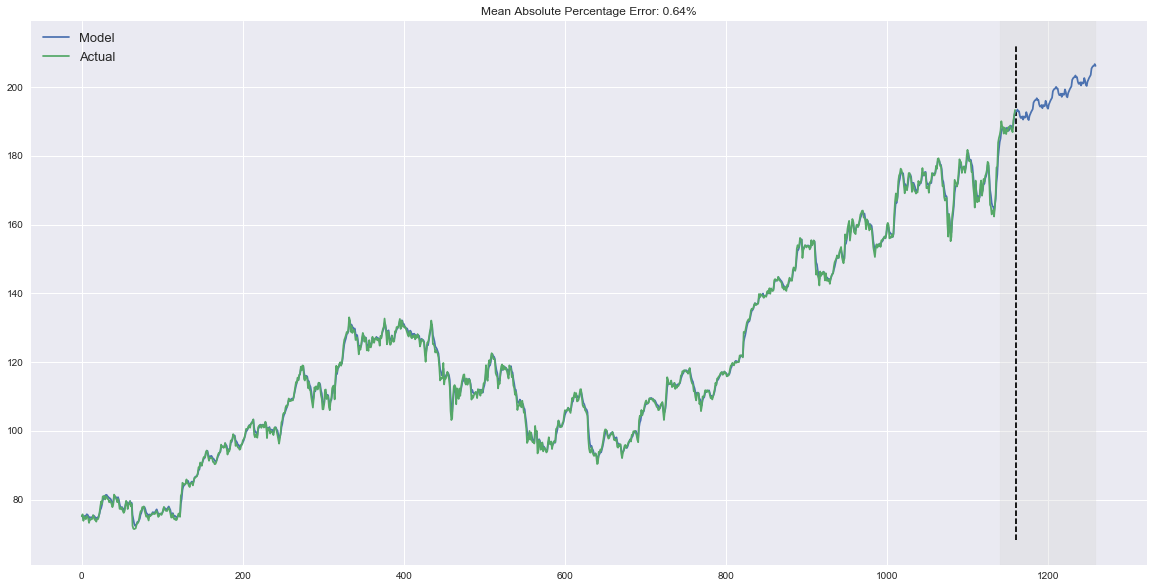

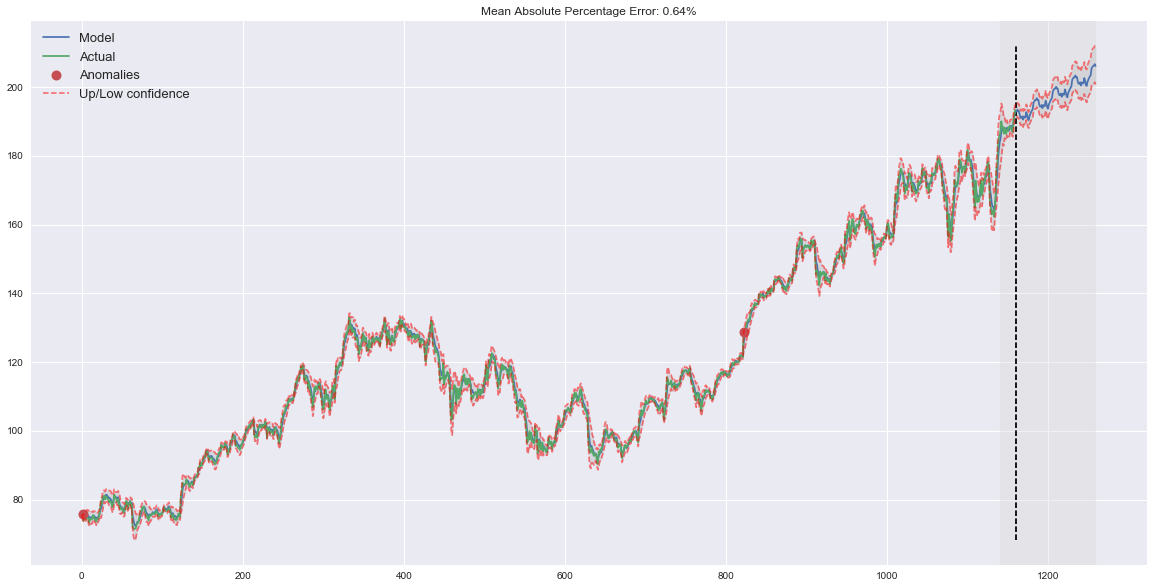

In [16]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - 时序数据集
        plot_intervals - 显示置信区间 
        plot_anomalies - 显示异常值 
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    

    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

# plotHoltWinters(stock_close['Close'])注意要用除掉后100数据的数值列表
plotHoltWinters(data)
plotHoltWinters(data, plot_intervals=True, plot_anomalies=True)

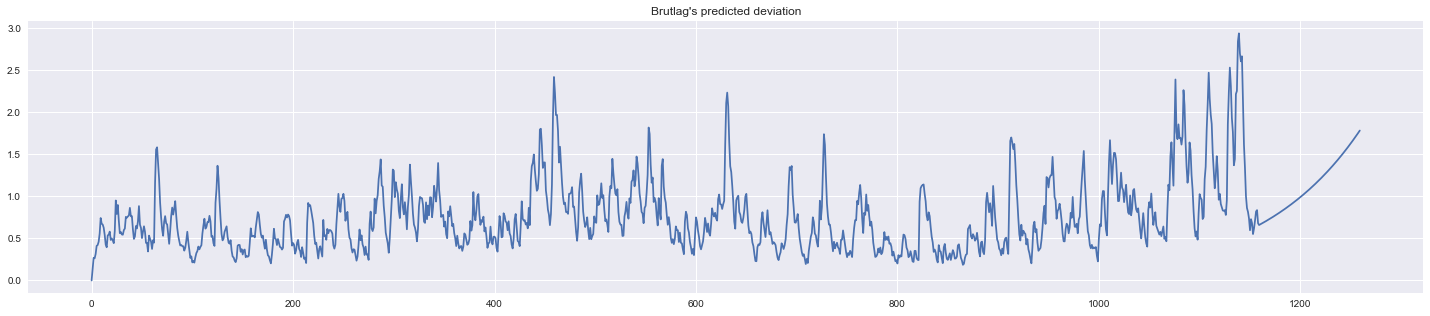

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

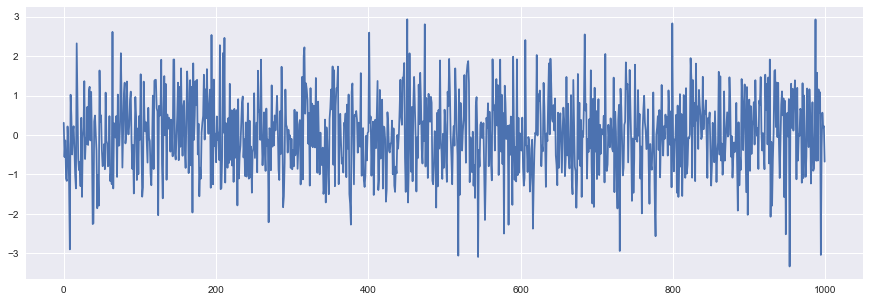

In [18]:
#白噪声图形
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
plt.plot(white_noise)

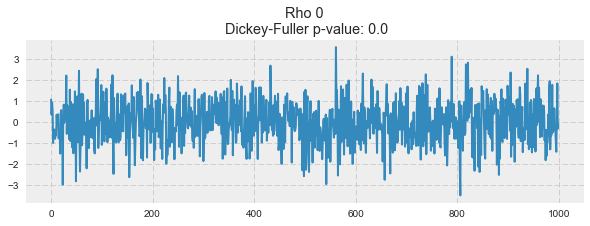

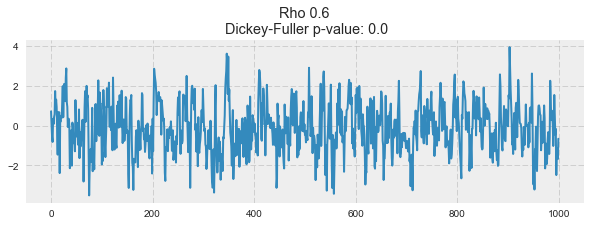

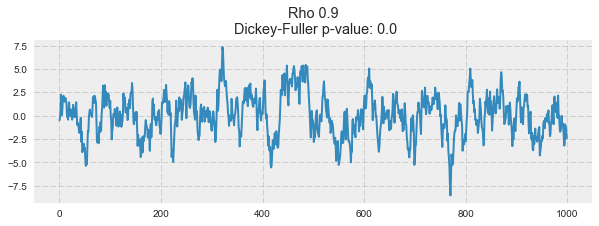

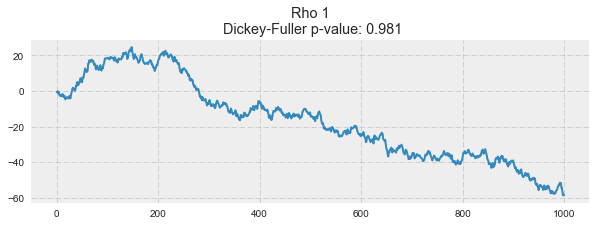

In [19]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

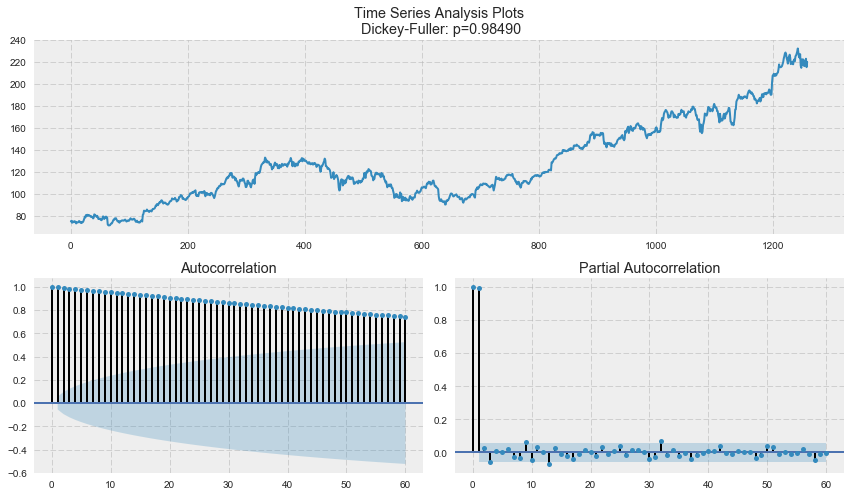

In [20]:
#ARIMA 模型

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        绘制时序及其ACF（自相关性函数）、PACF（偏自相关性函数），计算迪基-福勒检验

        y - 时序
        lags - ACF、PACF计算所用的时差
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(stock_close['Close'], lags=60)

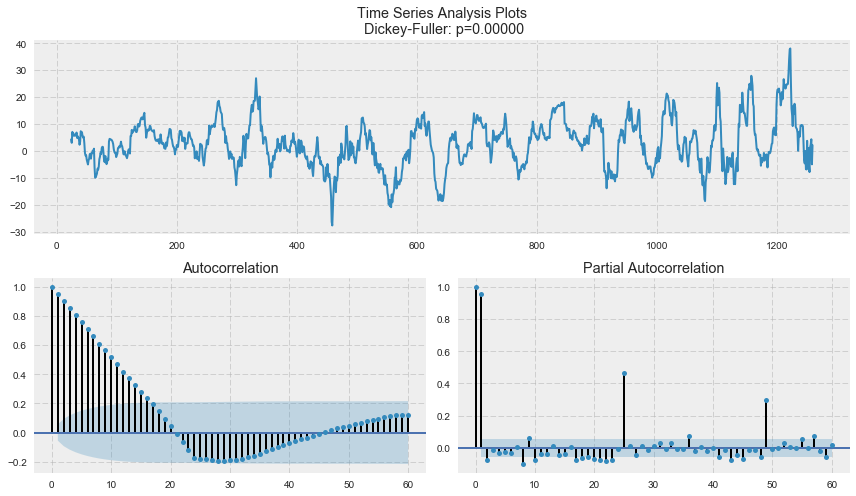

In [21]:
stock_diff = stock_close['Close'] - stock_close['Close'].shift(24)
tsplot(stock_diff[24:], lags=60)

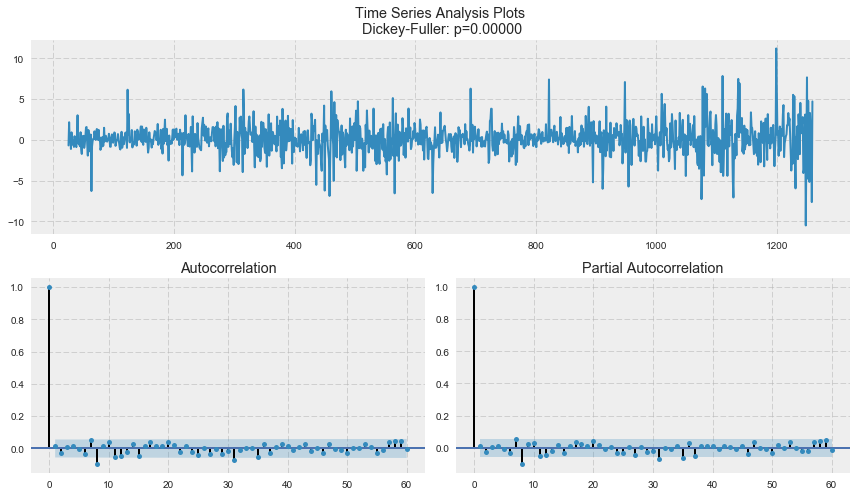

In [22]:
stock_diff = stock_close['Close'] - stock_close['Close'].shift(1)
tsplot(stock_diff[24+1:], lags=60)

In [23]:
# 设定初始值和初始范围
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24

# 创建参数所有可能组合的列表
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [24]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
    返回参数和相应的AIC的dataframe

        parameters_list - (p, q, P, Q)元组列表
        d - ARIMA模型的单整阶
        D - 季节性单整阶
        s - 季节长度
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # 由于有些组合不能收敛，所以需要使用try-except
        try:
            model=sm.tsa.statespace.SARIMAX(stock_close['Close'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # 保存最佳模型、AIC、参数
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # 递增排序，AIC越低越好
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimizeSARIMA(parameters_list, d, D, s)

# 设定参数为给出最低AIC的参数组合
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(stock_close['Close'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                 1260
Model:             SARIMAX(2, 1, 4)x(0, 1, 1, 24)   Log Likelihood               -2569.026
Date:                            Sat, 27 Oct 2018   AIC                           5154.052
Time:                                    20:46:26   BIC                           5195.003
Sample:                                         0   HQIC                          5169.456
                                           - 1260                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6522      0.071    -23.204      0.000      -1.792      -1.513
ar.L2         -0.8553      0.071  

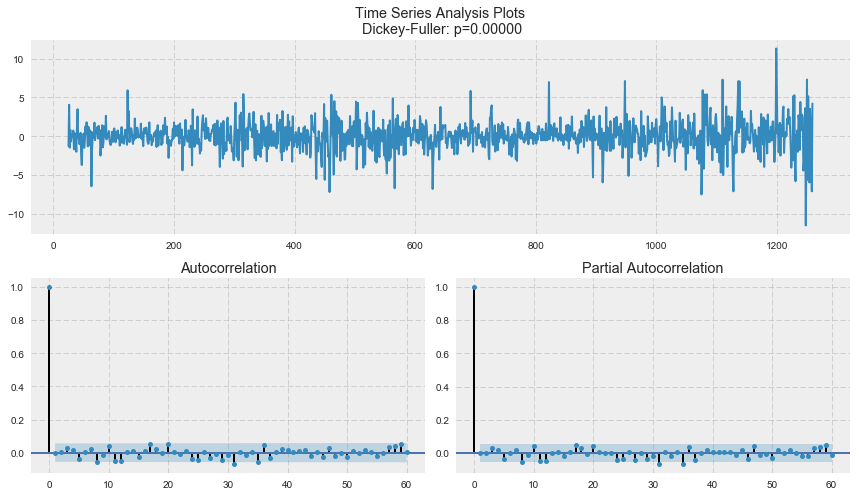

In [25]:
#模型的残余分量
tsplot(best_model.resid[24+1:], lags=60)

                actual  arima_model
Date                               
2013-10-25   75.137146          NaN
2013-10-28   75.697144          NaN
2013-10-29   73.811432          NaN
2013-10-30   74.985718          NaN
2013-10-31   74.671425          NaN
2013-11-01   74.290001          NaN
2013-11-04   75.250000          NaN
2013-11-05   75.064285          NaN
2013-11-06   74.417145          NaN
2013-11-07   73.212860          NaN
2013-11-08   74.365715          NaN
2013-11-11   74.150002          NaN
2013-11-12   74.287140          NaN
2013-11-13   74.375717          NaN
2013-11-14   75.451431          NaN
2013-11-15   74.998573          NaN
2013-11-18   74.089996          NaN
2013-11-19   74.221428          NaN
2013-11-20   73.571426          NaN
2013-11-21   74.448570          NaN
2013-11-22   74.257141          NaN
2013-11-25   74.820000          NaN
2013-11-26   76.199997          NaN
2013-11-27   77.994286          NaN
2013-11-29   79.438568          NaN
2013-12-02   78.747147      

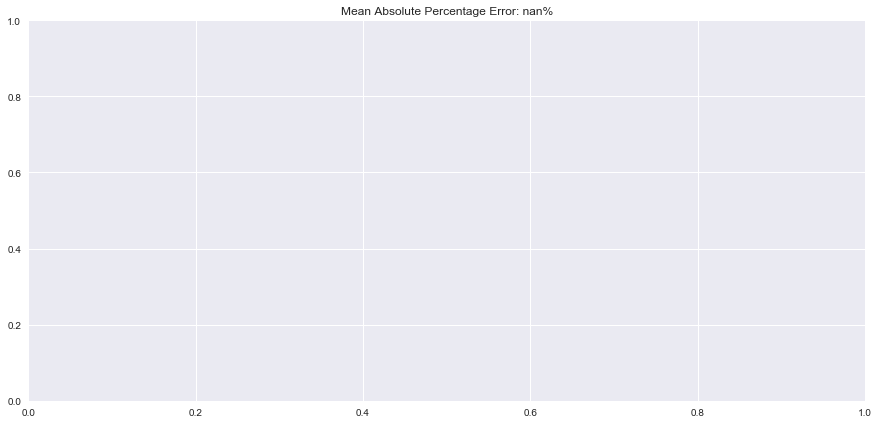

In [29]:
# stock_close = pd.read_excel('/Users/BartSu/Desktop/AAPL-Close.xlsx')
stock = pd.read_csv('/Users/BartSu/Desktop/AAPL-Close.csv', index_col=['Date'], parse_dates=['Date'])

def plotSARIMA(series, model, n_steps):
    """
        绘制模型预测值与实际数据对比图

        series - 时序数据集
        model - SARIMA模型
        n_steps - 预测未来的步数

    """
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # 平移s+d步，因为差分的缘故，前面的一些数据没有被模型观测到
    data['arima_model'][:s+d] = np.NaN
    print(data)
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # 计算误差，同样平移s+d步
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(stock, best_model, 100)
